# Automatic Trash Sorting


# Yasin Yari

# Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

# Dataset

In [2]:
# DATA_DIR = r"C:\Users\yasin\Downloads\Compressed\81794_189983_bundle_archive\Garbage classification\Garbage classification"

DATA_DIR = r"C:\Users\yasin\Downloads\Compressed\81794_189983_bundle_archive\Garbage classification\Garbage classification"
sz = 224
batch_size = 16

In [3]:
os.listdir(DATA_DIR)

['test', 'train', 'valid']

In [4]:
trn_dir = f'{DATA_DIR}\\train'
val_dir = f'{DATA_DIR}\\valid'
tst_dir = f'{DATA_DIR}\\test'

In [5]:
os.listdir(trn_dir)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [6]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard1.jpg',
 'C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard10.jpg',
 'C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard100.jpg',
 'C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard103.jpg',
 'C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard104.jpg']

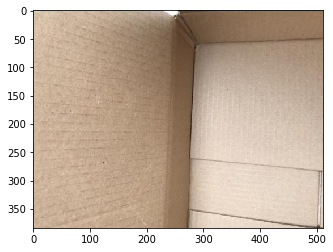

In [7]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

In [8]:
train_ds = datasets.ImageFolder(trn_dir)

In [9]:
train_ds.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [10]:
train_ds.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [11]:
train_ds.root

'C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train'

In [12]:
train_ds.imgs

[('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard1.jpg',
  0),
 ('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard10.jpg',
  0),
 ('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard100.jpg',
  0),
 ('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard103.jpg',
  0),
 ('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard104.jpg',
  0),
 ('C:\\Users\\yasin\\Downloads\\Compressed\\81794_189983_bundle_archive\\Garbage classification\\Garbage classification\\train\\cardboard\\cardboard105.jpg',
  0),
 ('C:\\Users\\yasin

# Transformation 

In [13]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)
test_ds = datasets.ImageFolder(tst_dir, transform=tfms)

In [14]:
len(train_ds) , len(valid_ds)  ,  len(test_ds) 

(1410, 839, 278)

# Dataloaders

In [15]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=8)

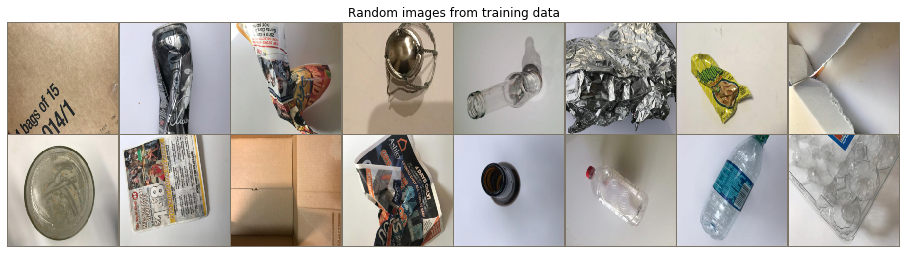

In [16]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Model-1

In [ ]:
class Model1(nn.Module):
    
    def __init__(self):
        super(Model1, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [ ]:
model = Model1()

model=model.cuda()


In [ ]:
model

# Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train

In [ ]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=10)

# Analyze results

In [17]:
def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [ ]:
evaluate_model(model, test_dl)

In [ ]:
visualize_model(model, test_dl)

In [ ]:
plot_errors(model, test_dl)

In [ ]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(7, 7))

# Data Augmentations 

In [18]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
   transforms.RandomRotation(15),
   transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(size=sz),  # Image net standards
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}\\train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}\\valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 1410
Valid size: 839 (0.37)


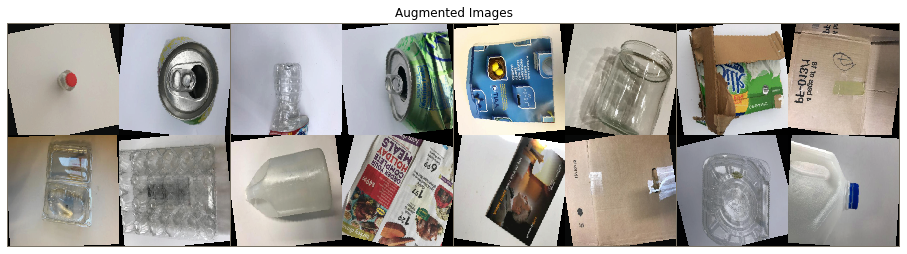

In [19]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

# Model-2

In [ ]:
# create model
model = Model1()
if use_gpu:
    model = model.cuda()
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=10)

In [ ]:
evaluate_model(model, test_dl) 

In [ ]:
plot_errors(model, test_dl)

# Model 3 (Pretrained CNN-Transfer Learning)

In [20]:
# load pre-trained ResNet50
model = load_pretrained_resnet50(model_path=None, num_classes=6)
model= model.cuda()
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [21]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=200)

Epoch 1/200
----------


C:\Users\yasin\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 Got 903.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.93935 Acc: 0.64043


C:\Users\yasin\waste sorter\utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


 Got 624.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.75292 Acc: 0.74374

Epoch 2/200
----------
 Got 1185.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.47369 Acc: 0.84043
 Got 734.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.34685 Acc: 0.87485

Epoch 3/200
----------
 Got 1238.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.34892 Acc: 0.87801
 Got 739.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.35448 Acc: 0.88081

Epoch 4/200
----------
 Got 1280.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.25607 Acc: 0.90780
 Got 738.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.34570 Acc: 0.87962

Epoch 5/200
----------
 Got 1298.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.22749 Acc: 0.92057
 Got 754.0 of correct prediction in 839.0 samples in validation set.
  v

  valid Loss: 0.16506 Acc: 0.95352

Epoch 37/200
----------
 Got 1403.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.04860 Acc: 0.99504
 Got 794.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.18534 Acc: 0.94636

Epoch 38/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01094 Acc: 0.99716
 Got 799.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.15744 Acc: 0.95232

Epoch 39/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.03056 Acc: 0.99716
 Got 798.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16388 Acc: 0.95113

Epoch 40/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00856 Acc: 0.99858
 Got 801.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16391 Acc: 0.95471

Epoch 41/200
----------
 Got 140

 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00805 Acc: 0.99787
 Got 795.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16953 Acc: 0.94756

Epoch 73/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00738 Acc: 0.99858
 Got 797.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17517 Acc: 0.94994

Epoch 74/200
----------
 Got 1404.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.05423 Acc: 0.99574
 Got 795.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.18715 Acc: 0.94756

Epoch 75/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00868 Acc: 0.99716
 Got 794.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16542 Acc: 0.94636

Epoch 76/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.

  train Loss: 0.01191 Acc: 0.99716
 Got 799.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16017 Acc: 0.95232

Epoch 108/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.03611 Acc: 0.99645
 Got 794.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17778 Acc: 0.94636

Epoch 109/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00840 Acc: 0.99787
 Got 800.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16504 Acc: 0.95352

Epoch 110/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00794 Acc: 0.99858
 Got 799.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17164 Acc: 0.95232

Epoch 111/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01205 Acc: 0.99645
 Got 794.0 of correct predict

 Got 797.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16405 Acc: 0.94994

Epoch 143/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01103 Acc: 0.99787
 Got 798.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17393 Acc: 0.95113

Epoch 144/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01030 Acc: 0.99787
 Got 798.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17384 Acc: 0.95113

Epoch 145/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01003 Acc: 0.99716
 Got 797.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16658 Acc: 0.94994

Epoch 146/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00752 Acc: 0.99787
 Got 799.0 of correct prediction in 839.0 samples in validation 

 Got 794.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17188 Acc: 0.94636

Epoch 178/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01256 Acc: 0.99716
 Got 796.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16515 Acc: 0.94875

Epoch 179/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00926 Acc: 0.99858
 Got 798.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.17254 Acc: 0.95113

Epoch 180/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01849 Acc: 0.99787
 Got 799.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.16669 Acc: 0.95232

Epoch 181/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.04568 Acc: 0.99645
 Got 792.0 of correct prediction in 839.0 samples in validation 

In [22]:
evaluate_model(model, test_dl)

accuracy: 93.17


100%|██████████| 18/18 [00:11<00:00,  1.55it/s]


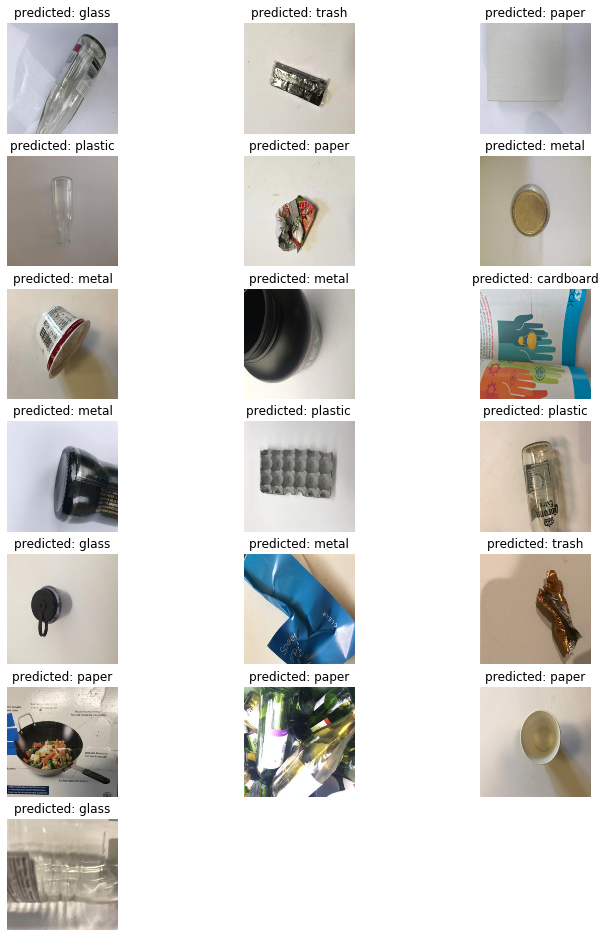

19 images out of 278 were misclassified.


In [23]:
plot_errors(model, test_dl)

# confusion matrix

100%|██████████| 18/18 [00:11<00:00,  1.64it/s]


[[0.95 0.   0.   0.05 0.   0.  ]
 [0.   0.91 0.04 0.02 0.04 0.  ]
 [0.   0.   0.98 0.   0.   0.02]
 [0.02 0.   0.02 0.95 0.02 0.  ]
 [0.   0.06 0.02 0.02 0.89 0.02]
 [0.   0.   0.07 0.07 0.   0.87]]


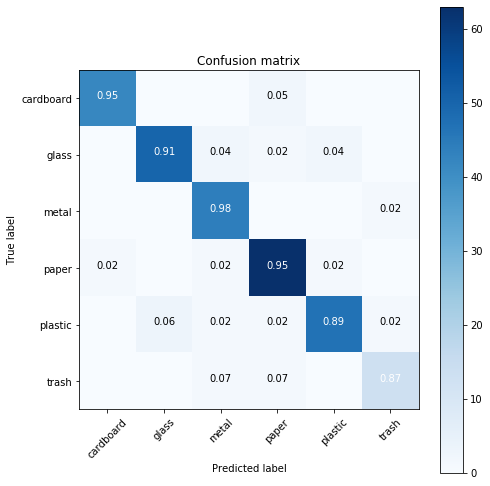

In [24]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(7, 7))

# Model 4 (Pretrained CNN-Transfer Learning)

In [25]:
#load pretrained DenseNet121
model_conv = torchvision.models.densenet121(pretrained='imagenet')
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 6)
model=model_conv
model = model.cuda()

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [26]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=200)

Epoch 1/200
----------
 Got 870.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 1.00771 Acc: 0.61702
 Got 700.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.47495 Acc: 0.83433

Epoch 2/200
----------
 Got 1121.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.54948 Acc: 0.79504
 Got 736.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.36943 Acc: 0.87723

Epoch 3/200
----------
 Got 1251.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.33059 Acc: 0.88723
 Got 746.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.30223 Acc: 0.88915

Epoch 4/200
----------
 Got 1283.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.27334 Acc: 0.90993
 Got 765.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.28193 Acc: 0.91180

Epoch 5/200
----------
 Got 1312.0 of correct prediction in 1410.0 sample

 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01760 Acc: 0.99787
 Got 783.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25310 Acc: 0.93325

Epoch 37/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01100 Acc: 0.99787
 Got 780.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.23694 Acc: 0.92968

Epoch 38/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.04451 Acc: 0.99645
 Got 776.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.26138 Acc: 0.92491

Epoch 39/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.04399 Acc: 0.99645
 Got 777.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.26190 Acc: 0.92610

Epoch 40/200
----------
 Got 1404.0 of correct prediction in 1410.0 samples in training set.

  train Loss: 0.00891 Acc: 0.99787
 Got 782.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24294 Acc: 0.93206

Epoch 72/200
----------
 Got 1402.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01460 Acc: 0.99433
 Got 777.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25728 Acc: 0.92610

Epoch 73/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01278 Acc: 0.99716
 Got 777.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25260 Acc: 0.92610

Epoch 74/200
----------
 Got 1409.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00884 Acc: 0.99929
 Got 781.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.23658 Acc: 0.93087

Epoch 75/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00883 Acc: 0.99787
 Got 779.0 of correct prediction 

 Got 777.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24434 Acc: 0.92610

Epoch 107/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00898 Acc: 0.99645
 Got 780.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24500 Acc: 0.92968

Epoch 108/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01664 Acc: 0.99645
 Got 776.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24811 Acc: 0.92491

Epoch 109/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01458 Acc: 0.99787
 Got 778.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24964 Acc: 0.92729

Epoch 110/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01386 Acc: 0.99858
 Got 778.0 of correct prediction in 839.0 samples in validation 

 Got 779.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.23188 Acc: 0.92849

Epoch 142/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.03562 Acc: 0.99787
 Got 775.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25768 Acc: 0.92372

Epoch 143/200
----------
 Got 1409.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00744 Acc: 0.99929
 Got 771.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25939 Acc: 0.91895

Epoch 144/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.02503 Acc: 0.99787
 Got 779.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.22706 Acc: 0.92849

Epoch 145/200
----------
 Got 1405.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01429 Acc: 0.99645
 Got 773.0 of correct prediction in 839.0 samples in validation 

 Got 781.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25405 Acc: 0.93087

Epoch 177/200
----------
 Got 1407.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01078 Acc: 0.99787
 Got 775.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.25941 Acc: 0.92372

Epoch 178/200
----------
 Got 1406.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.02902 Acc: 0.99716
 Got 780.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.23911 Acc: 0.92968

Epoch 179/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.01233 Acc: 0.99858
 Got 777.0 of correct prediction in 839.0 samples in validation set.
  valid Loss: 0.24339 Acc: 0.92610

Epoch 180/200
----------
 Got 1408.0 of correct prediction in 1410.0 samples in training set.
  train Loss: 0.00923 Acc: 0.99858
 Got 783.0 of correct prediction in 839.0 samples in validation 

In [27]:
evaluate_model(model, test_dl)

accuracy: 91.01


100%|██████████| 18/18 [00:12<00:00,  1.40it/s]


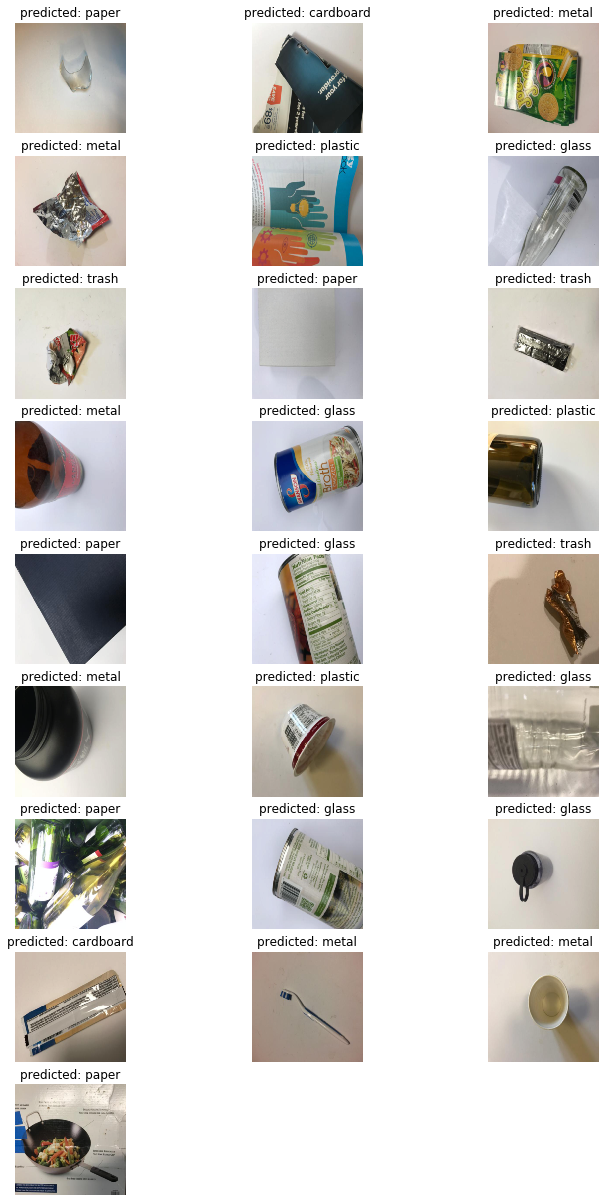

25 images out of 278 were misclassified.


In [28]:
plot_errors(model, test_dl)

# confusion matrix

100%|██████████| 18/18 [00:12<00:00,  1.49it/s]


[[0.93 0.   0.   0.07 0.   0.  ]
 [0.   0.93 0.02 0.04 0.02 0.  ]
 [0.   0.07 0.91 0.   0.   0.02]
 [0.02 0.   0.02 0.95 0.02 0.  ]
 [0.   0.06 0.02 0.   0.89 0.04]
 [0.07 0.   0.2  0.   0.07 0.67]]


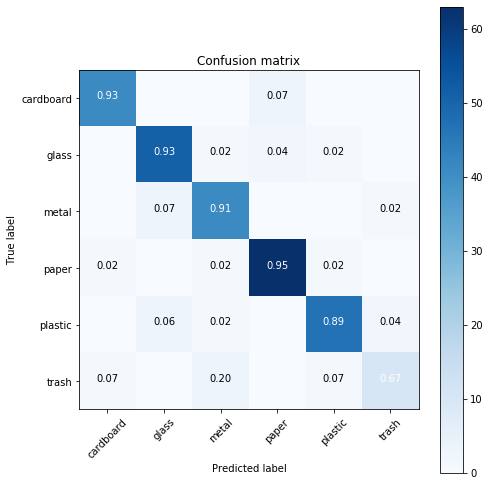

In [29]:
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(7, 7))